## Import Necessary Libraries

In [1]:
# Image processing
import cv2 
from PIL import Image

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


# File & config handling
import shutil
import yaml
from glob import glob   
import os
from pprint import pprint

# Progress bars
from tqdm import tqdm

# Data handling
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

#Pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Object detection model
from torchvision.datasets import VOCDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


## Data Preprocessing

In [2]:
#load yaml file
def load_config(config_file="config.yaml"):
    with open(config_file, "r") as file:
        config=yaml.safe_load(file)
    return config 

config=load_config("config.yaml")

In [3]:
def create_dataframe(root):
    xml_files = glob(f"{root}/*/*.xml")
    data_list = []

    for xml_file in tqdm(xml_files, desc="Parsing XML", colour="cyan"):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        #Find filepath
        img_path=xml_file.replace("Annotations", "JPEGImages").replace(".xml", ".jpg")

        # Find filename
        filename = root.findtext('filename')
    
        # Find image size
        size_tag = root.find('size')
        img_width = int(size_tag.findtext('width', default='0'))
        img_height = int(size_tag.findtext('height', default='0'))

        for obj in root.findall('object'):
            category = obj.findtext('name')
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.findtext('xmin', default='0')))
            ymin = int(float(bndbox.findtext('ymin', default='0')))
            xmax = int(float(bndbox.findtext('xmax', default='0')))
            ymax = int(float(bndbox.findtext('ymax', default='0')))

            data_list.append({
                'filename': filename,
                'width': img_width,
                'height': img_height,
                'category': category,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'img_path': img_path
            })

    print("DataFrame creation complete.")
    return pd.DataFrame(data_list)

voc_df= create_dataframe(config['root'])


Parsing XML: 100%|██████████| 17125/17125 [00:06<00:00, 2551.75it/s]


DataFrame creation complete.


In [4]:
voc_df.head()

,filename,width,height,category,xmin,ymin,xmax,ymax,img_path
0,2007_000027.jpg,486,500,person,174,101,349,351,../VOCdetection/VOCdevkit/VOC2012/JPEGImages/2...
1,2007_000032.jpg,500,281,aeroplane,104,78,375,183,../VOCdetection/VOCdevkit/VOC2012/JPEGImages/2...
2,2007_000032.jpg,500,281,aeroplane,133,88,197,123,../VOCdetection/VOCdevkit/VOC2012/JPEGImages/2...
3,2007_000032.jpg,500,281,person,195,180,213,229,../VOCdetection/VOCdevkit/VOC2012/JPEGImages/2...
4,2007_000032.jpg,500,281,person,26,189,44,238,../VOCdetection/VOCdevkit/VOC2012/JPEGImages/2...


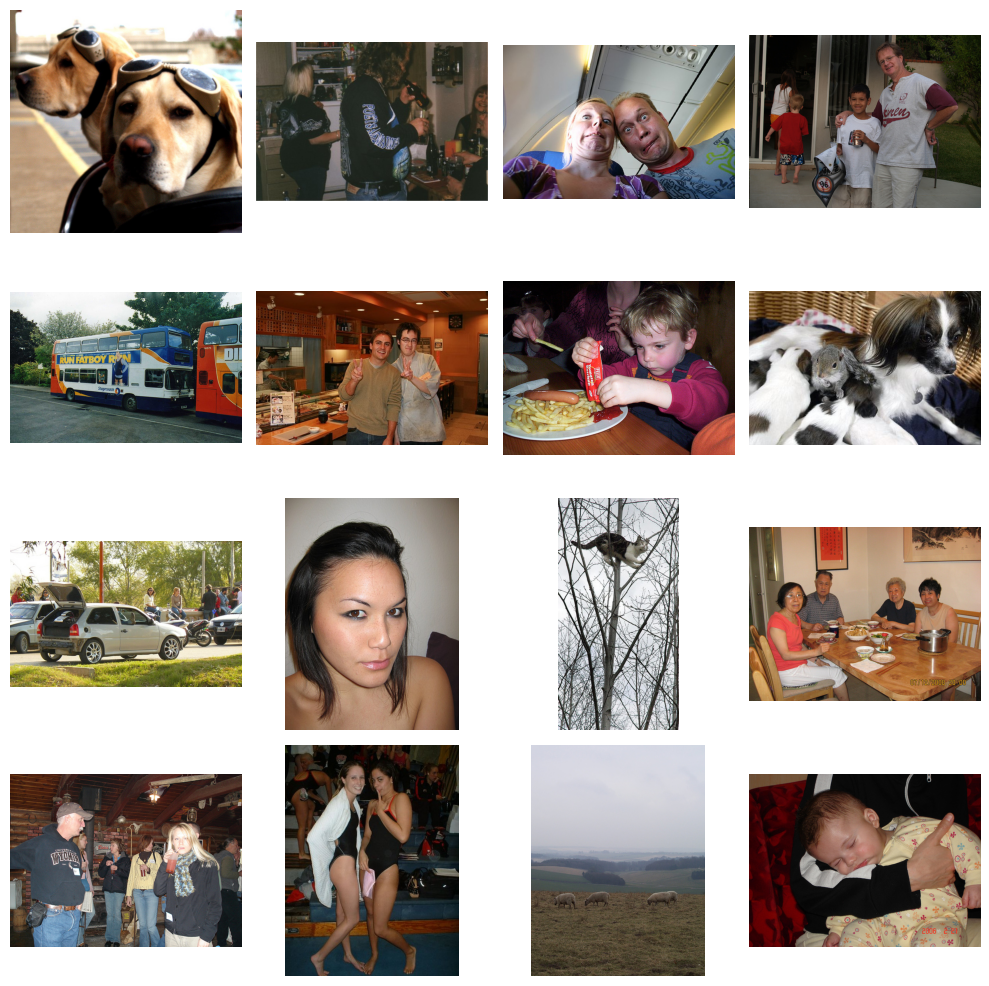

In [5]:
random_idx = np.random.randint(0,len(voc_df), 16)
fig, axes=plt.subplots(4,4, figsize=(10,10))

for i,ax in enumerate(axes.flat):
    img_path = voc_df.iloc[random_idx[i]]['img_path']
    img = plt.imread(img_path)
    ax.imshow(img)
    
    ax.axis("off")

plt.tight_layout()
plt.show()

/tmp/ipykernel_2927485/1917248411.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel', ax=axes)
/tmp/ipykernel_2927485/1917248411.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


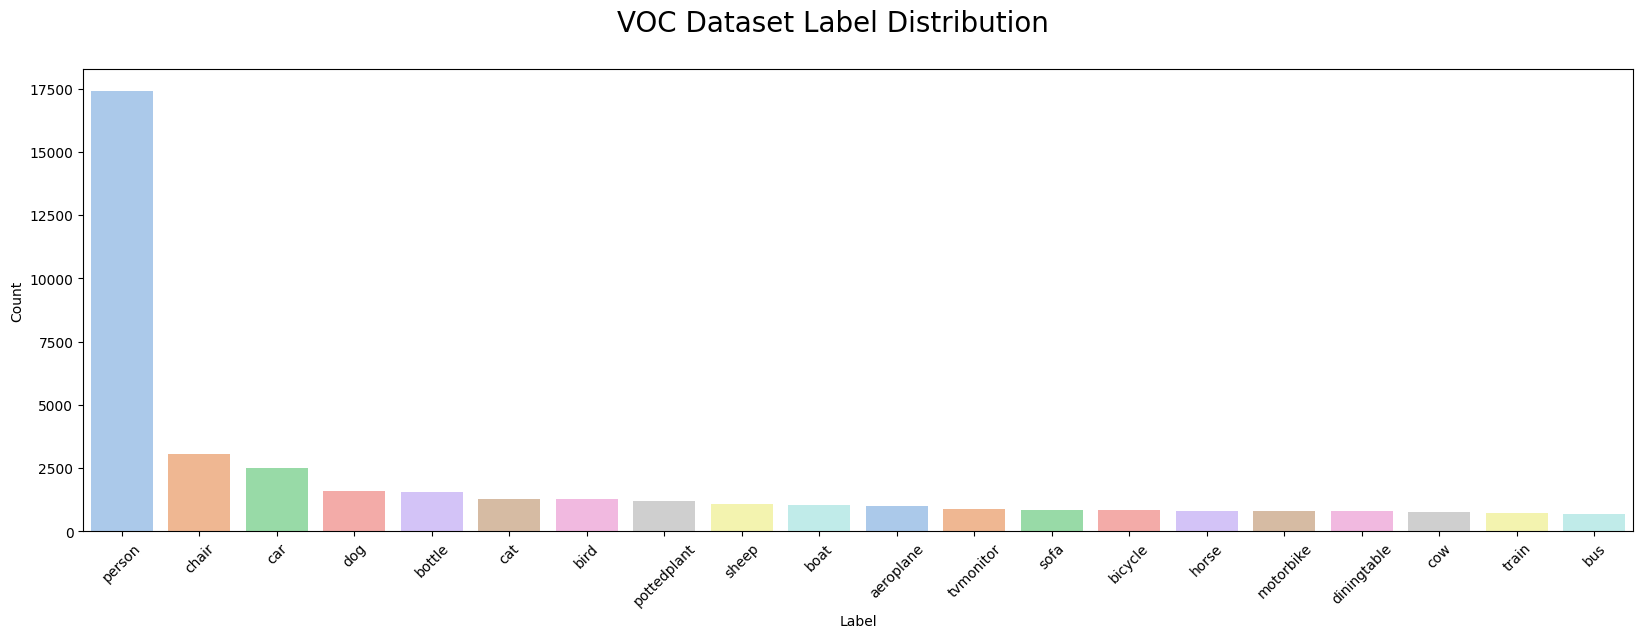

In [6]:
fig, axes = plt.subplots(1,1, figsize=(20, 6))
label_counts = voc_df['category'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel', ax=axes)
axes.set_xlabel('Label')
axes.set_ylabel('Count')
axes.set_xticklabels(label_counts.index, rotation=45)
fig.suptitle('VOC Dataset Label Distribution', fontsize=20)

plt.show()

In [7]:
def get_transforms(img_size=224, is_training=True):
    if is_training:
        transform =A.Compose([
            A.RandomResizedCrop(size=(img_size, img_size)),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1))
    else:
        transform=A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
            ToTensorV2()
        ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    return transform    

train_transform=get_transforms(224 ,is_training=True)
val_transform=get_transforms(224 ,is_training=False)

In [8]:
class VOCDetection(VOCDetection):
    def __init__(self, root, year='2012', image_set='train', download=False, transform=None):
        super().__init__(root, year, image_set, download)
        self.categories = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                          'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
                          'sheep', 'sofa', 'train', 'tvmonitor']
        self.transform = transform

    def __getitem__(self, item):
        img, anno = super().__getitem__(item)
        
        # Extract boxes and labels
        boxes, labels = [], []
        for obj in anno['annotation']['object']:
            box = [int(float(obj["bndbox"][k])) for k in ["xmin", "ymin", "xmax", "ymax"]]
            boxes.append(box)
            labels.append(self.categories.index(obj["name"]))
            
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=np.array(img), bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = torch.FloatTensor(transformed['bboxes'])
            labels = torch.LongTensor(transformed['labels'])

        return img, boxes, labels
    

## FasterCNN Application

In [9]:
def collate_fn(batch):
    images, boxes, labels = zip(*batch)
    return list(images), list(boxes), list(labels)

categories = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
            'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
            'sheep', 'sofa', 'train', 'tvmonitor']


#***************************************#

def save_checkpoint(model, optimizer, epoch, map_value,history, filename):
    """Save model checkpoint to file"""
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'map_value': map_value, 
        'history': history
    }, filename)

    # print(f"Checkpoint saved: {filename}")

#*****************************************#

def load_checkpoint(model, optimizer, filename):
    """Load model checkpoint from file"""

    epochs_list=[]
    train_loss = []
    map_values=[]

    if not os.path.isfile(filename):
        print(f"Checkpoint file {filename} not found! Create new...")
        return 0, 0.0, epochs_list, train_loss, map_values
    
    checkpoint=torch.load(filename)
    
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch=checkpoint['epoch']+1
    last_map=checkpoint.get('map_value', 0.0)

    if isinstance(last_map, dict):
        last_map = last_map.get('map', 0.0)

    if 'history' in checkpoint:
        history_data=checkpoint['history']
        
        epochs_list=history_data.get('epochs_list', [])
        train_loss=history_data.get('train_loss', [])
        map_values=history_data.get('map_values', [])
        map_per_class=history_data.get('map_per_class', None)

        print(f"Loaded history with {len(epochs_list)} entries")


    print(f"Loaded checkpoint from epoch {start_epoch+1} with mAP: {last_map:.4f} ")
    
    return start_epoch,last_map, epochs_list, train_loss, map_values, map_per_class

In [10]:
def filter_empty_boxes(images, boxes, labels):
    """
    Filter out images and targets where boxes tensor is empty
    """
    filtered_images = []
    filtered_boxes = []
    filtered_labels = []
    
    for image, box, label in zip(images, boxes, labels):
        if len(box) > 0:
            filtered_images.append(image)
            filtered_boxes.append(box)
            filtered_labels.append(label)
    
    return filtered_images, filtered_boxes, filtered_labels

def train():
    train_dataset = VOCDetection(root="./", year="2012", download=False, image_set="train", transform=train_transform)
       
    train_loader = DataLoader(train_dataset,
                            batch_size=config['batch-size'],
                            shuffle=True,
                            num_workers=config['num-workers'],
                            drop_last=True,
                            collate_fn=collate_fn)
    val_dataset = VOCDetection(root="./", year="2012", download=False, image_set="val", transform=val_transform)
    
    val_loader = DataLoader(val_dataset,
                        batch_size=config['batch-size'],
                        shuffle=False,
                        num_workers=config['num-workers'],
                        drop_last=False,
                        collate_fn=collate_fn)

    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, trainable_backbone_layers=5)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=config['num-classes'])
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.set_device(0)
    
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=config["learning-rate"], momentum=0.9)
    
    #Load the saved model 
    start_epoch, last_map, epochs_list, train_loss, map_values, map_per_class=load_checkpoint(model, optimizer,config['last_checkpoint_path']) 
    best_score=0.0
    if os.path.isfile(config['best_checkpoint_path']):
        try:
            ckpt=torch.load(config['best_checkpoint_path'], map_location="cpu")
            score_val=ckpt.get('map_value', 0.0)
            if hasattr(score_val, 'item'): score_val=score_val.item()
            best_score=float(score_val)

        except Exception:pass


    num_epochs = config["epochs"]

    for epoch in range(start_epoch, num_epochs):
        model.train()  
        progress_bar = tqdm(train_loader, desc="Training", colour="Green")

        epoch_losses=[]

        for i, (imgs, boxes, labels) in enumerate(progress_bar):  
            # Filter out samples with empty boxes
            imgs, boxes, labels = filter_empty_boxes(imgs, boxes, labels)
            
            if len(imgs) == 0:
                continue
                
            imgs = [image.to(device) for image in imgs]
            
            # Convert to dictionary format for model
            targets = [{"boxes": box.to(device), "labels": label.to(device)} 
                    for box, label in zip(boxes, labels)]

            # Forward
            losses = model(imgs, targets)
            total_loss = sum([loss for loss in losses.values()])
    
            # Backward
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        
            epoch_losses.append(total_loss.item())
            ave_loss = np.mean(epoch_losses)
        
            progress_bar.set_description(f"Epoch: {epoch+1}/{num_epochs} Loss: {ave_loss:.4f}")

        epochs_list.append(epoch+1)
        train_loss.append(ave_loss)

        #------------- Validation-----------------
        progress_bar = tqdm(val_loader, desc="Validation", colour="Cyan")
        metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)
        model.eval()
        
        for i,(imgs, boxes, labels) in enumerate(progress_bar):
            # Filter out samples with empty boxes
            imgs, boxes, labels = filter_empty_boxes(imgs, boxes, labels)
            
            # Skip this batch if all samples had empty boxes
            if len(imgs) == 0:
                continue
                
            imgs = [image.to(device) for image in imgs] 
            with torch.no_grad():
                outputs = model(imgs)
                
            preds = []
            for output in outputs:
                preds.append({
                    "boxes": output["boxes"].to("cpu"),
                    "scores": output["scores"].to("cpu"),
                    "labels": output["labels"].to("cpu"),
                })

            targets = []
            for box, label in zip(boxes, labels):
                targets.append({
                    "boxes": box,
                    "labels": label,
                })  

            metric.update(preds, targets)

        #Calculate mAP@50
        map_results = metric.compute()
        map_per_class=map_results['map_per_class'].cpu().numpy()

        current_map=map_results['map_50'].item()
        map_values.append(current_map)
        metric.reset()

        current_history={
            'epochs_list': epochs_list,
            'train_loss': train_loss,
            'map_values': map_values,
            'map_per_class': map_per_class
        }

        #Save the model
        save_checkpoint(model, optimizer, epoch, current_map, current_history, config['last_checkpoint_path'])            

        #Save the best model
        if  current_map > best_score:
            best_score=map_results['map_50']
            save_checkpoint(model, optimizer, epoch, best_score,current_history, config['best_checkpoint_path'])
            print(f"New best model saved with mAP: {best_score:.4f}")

    #-------------Visualize Metrics----------------

    fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))

    #Plot the final training loss
    ticks=list(range(0, epochs_list[-1]+1,10)) #Set custom x-axis ticks to show 0, 10, 20, 30, etc.

    ax1.plot(epochs_list, train_loss, 'b-', linewidth=2, label= "Loss")
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)
    ax1.legend()
    ax1.set_xticks(ticks)

    #Plot the mAP
    ax2.plot(epochs_list, map_values, 'r-', linewidth=2, label= "mAP")
    ax2.set_title("Validation mAP@50")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("mAP")
    ax2.grid(True)
    ax2.legend()
    ax2.set_xticks(ticks)

    plt.tight_layout()

    #*Plot the mAP for each classes 
    plt.figure(figsize=(10,4))
    df=pd.Series(map_per_class, index=categories[1:])
    df=df.sort_values(ascending=False)

    sns.barplot(x=df.index , y=df.values, palette='pastel')
    plt.title("Validation AP@50 per Class")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")
    plt.ylabel("AP@50")
    plt.tight_layout()
    
    plt.show()

/tmp/ipykernel_2927485/1466157214.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(filename)


Loaded history with 60 entries
Loaded checkpoint from epoch 61 with mAP: 0.7002 


/tmp/ipykernel_2927485/2342099886.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load(config['best_checkpoint_path'], map_location="cpu")
/tmp/ipykernel_292

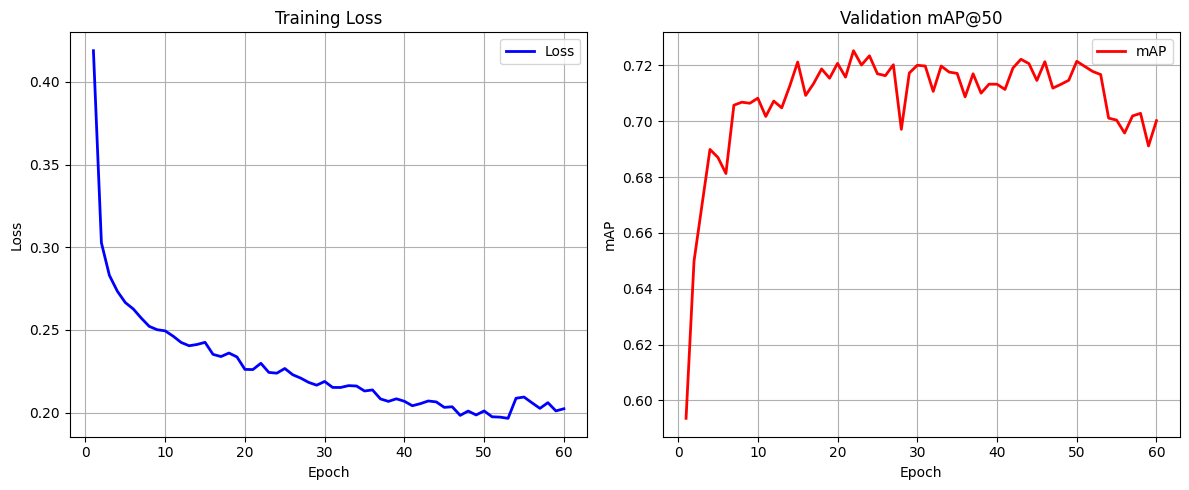

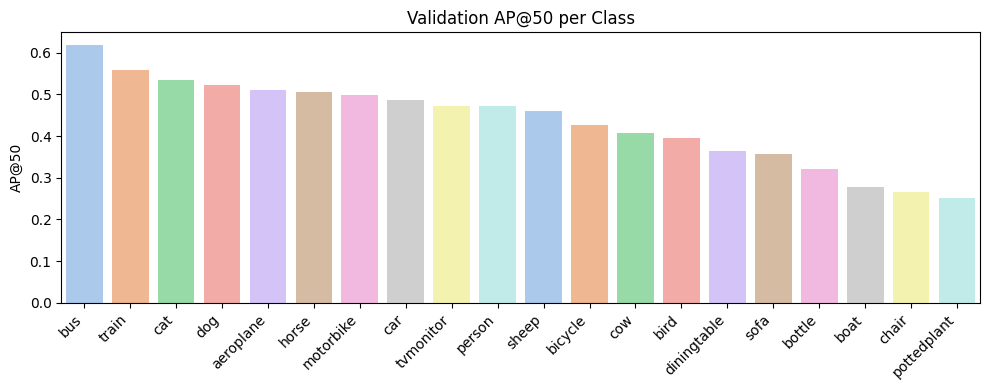

In [11]:
train()

## Testing the trained model

In [12]:
def test(threshold=0.5):

    # Load model
    model = fasterrcnn_resnet50_fpn(weights=None)  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=config['num-classes'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Load the checkpoint
    checkpoint = torch.load(config['best_checkpoint_path'], map_location=device)
    if 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])

    model.to(device)
    model.eval()

    test_paths = glob("Images/*")
    num_images = len(test_paths)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    #Flattern images
    if num_images == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Set up colormap for different classes
    cmap = plt.cm.get_cmap('tab20b', len(categories))
    
    for idx, image_path in enumerate(test_paths):

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Save original image for display
        display_image = image.copy()
        
        axes[idx].imshow(display_image)
        
        dummy_boxes = []  
        dummy_labels = []  
        
        transformed = val_transform(
            image=image,
            bboxes=dummy_boxes,  
            labels=dummy_labels   
        )
        
        img_tensor = transformed["image"].to(device)
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        
        with torch.no_grad():
            prediction = model(img_tensor)
        
        # Extract results from the image prediction
        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        

        orig_height, orig_width = display_image.shape[:2]
        transform_height, transform_width = 224, 224  
        
        #* Draw bounding boxes on displayed image
        for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
            if score >= threshold:
                # Scale box coordinates back to original image dimensions
                xmin, ymin, xmax, ymax = box
                
                # Convert from normalized coordinates 
                xmin = xmin * (orig_width / transform_width)
                ymin = ymin * (orig_height / transform_height)
                xmax = xmax * (orig_width / transform_width)
                ymax = ymax * (orig_height / transform_height)
                
                width, height = xmax - xmin, ymax - ymin
                
                color = cmap(label % len(categories))
                rect = patches.Rectangle(
                    (xmin, ymin), width, height,
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                axes[idx].add_patch(rect)
                
                axes[idx].text(
                    xmin, ymin - 5, 
                    f"{categories[label]}: {score:.2f}",
                    fontsize=8, color='black', 
                    bbox=dict(facecolor=color, alpha=0.7)
                )
        
        # Set title and turn off axis for this subplot
        axes[idx].axis("off")
    
        
    plt.tight_layout()
    plt.suptitle("Detection  Results", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

/tmp/ipykernel_2927485/425620088.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config['best_checkpoint_path'], map_location=device)
/tmp/ipyke

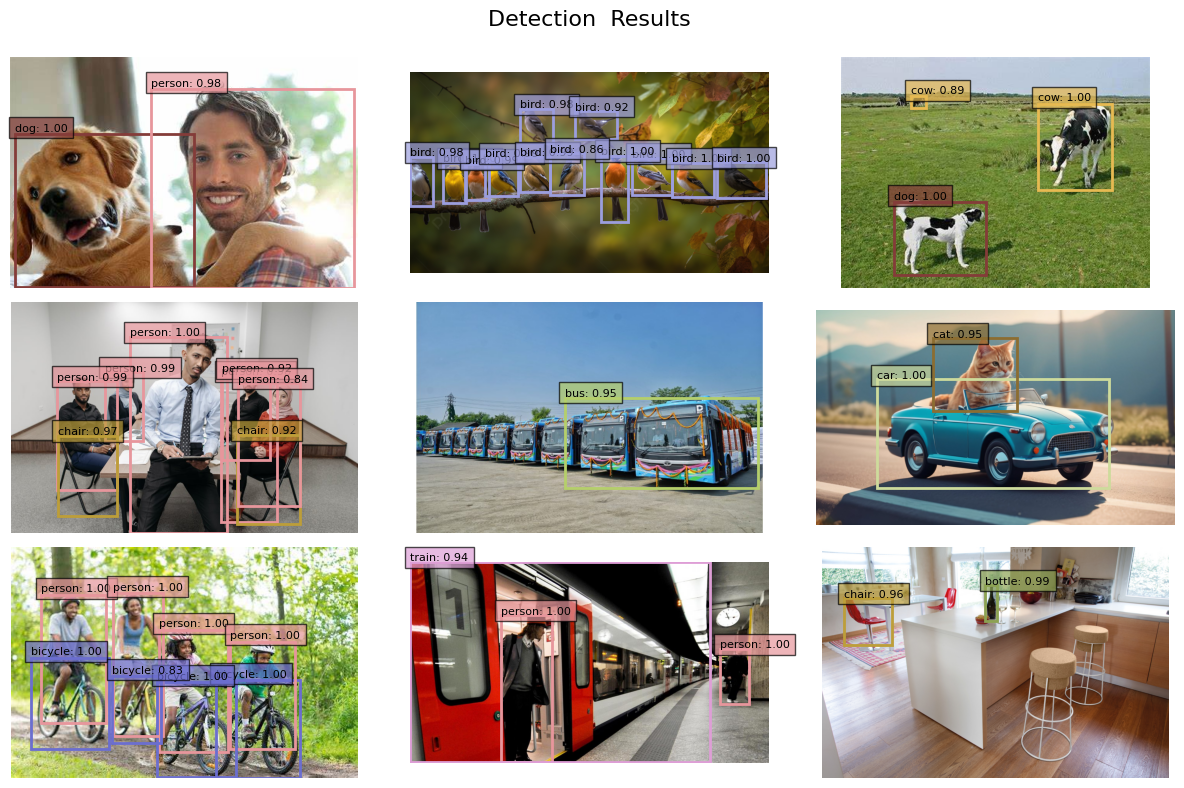

In [13]:
test(0.8)